练习目标：
* 完全自主地实现一下unit1_02-1里面的一些代码，锻炼pytorch建模能力。

In [1]:
## 首先，我们需要加载一些数据。出于寓教于乐的目的，我们使用自己的图片，而非给好的图片。
## 开发出给图片加噪声的函数。要给图片便利地加噪。
## 然后构建一个encoderdecoder模型，能够将图片压缩之后恢复成原来的大小。
## 要将恢复成原来大小的图片和原图进行损失对比。
## 开始训练的流程：进行推导，计算损失，优化。
## 最后给一个随机函数，也能够恢复出一张图片出来。

In [1]:
import random, os, tqdm, time, json
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

random.seed(618)
np.random.seed(907)

new_base_path = os.path.join(
    "/Users/minkexiu/Downloads/",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

storage dir: /Users/minkexiu/Downloads/GitHub/ML_runCodeFromBook/HuggingFace扩散模型
code dir: /Users/minkexiu/Documents/GitHub/ML_runCodeFromBook/HuggingFace扩散模型


In [2]:
import torch
import torchvision
from torch import nn

In [3]:
device = torch.device("mps")
print(f'Using device: {device}')

Using device: mps


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [49]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    plt.imshow(grid_im)
    
class HanfuDataset(Dataset): 
    def __init__(self, root_dir, transform=None):  
        self.root_dir = root_dir  
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]  
        self.transform = transform
        
    def __len__(self):  
        return len(self.image_paths)  

    def __getitem__(self, idx):  
        img_path = self.image_paths[idx]  
        image = Image.open(img_path)#.convert('L')  # 转换为灰度图片  
        if self.transform:  
            image = self.transform(image)  
        return image

transform = transforms.Compose([  
    transforms.Resize((700, 500)),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  # 灰度图片的归一化  
]) 
dataset = HanfuDataset(create_originalData_path("14 士庶巾服/"), transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)  

In [50]:
for x in data_loader:
    # print(x)
    break

In [51]:
## 我们自己实现一遍corrupt：
def corrupt(x, amount):
    '''
    实际上是不同的图加的噪音程度不一样。
    就是说，给x加上amount程度的【正态分布noise】。
    '''
    ## 生成一个形状和x一样的正态分布随机数。
    noise = torch.randn_like(x)
    ## 接下来的部分是照抄的。
    amount = amount.view(-1, 1,1,1)
    return (1-amount) * x + amount * noise

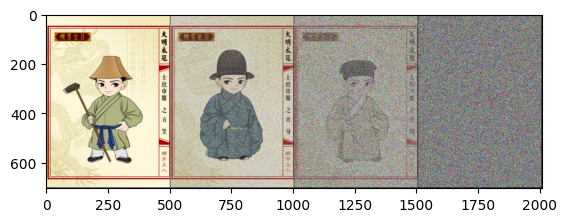

In [60]:
amount = torch.linspace(0, 1, x.shape[0])
## 从左到右，加的噪声越来越多。
show_images(
    corrupt(x, amount)
)

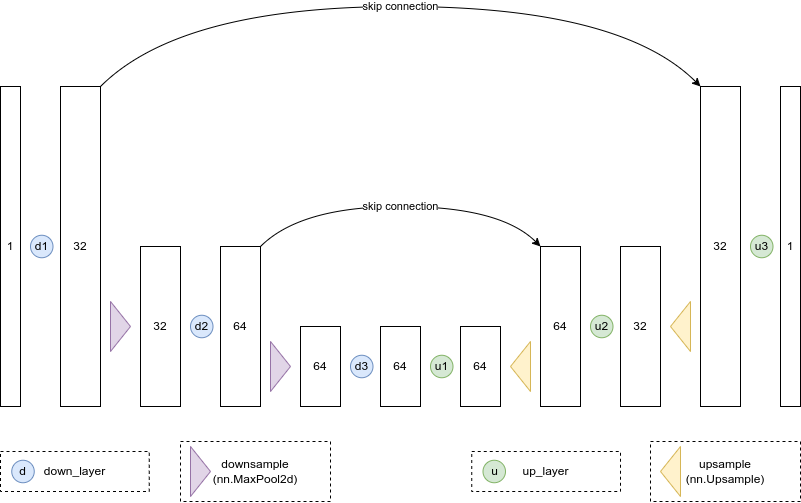

In [99]:
class BasicUNet(nn.Module):
    def __init__(self, in_channel = 3, out_channel = 3):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = in_channel,
                    out_channels = 32, 
                    kernel_size=5, padding=2
                ),
                nn.Conv2d(
                    in_channels = 32,
                    out_channels = 64, 
                    kernel_size=5, padding=2
                ),
                nn.Conv2d(
                    in_channels = 64,
                    out_channels= 64, 
                    kernel_size=5, padding=2
                ),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 64,
                    out_channels = 64, 
                    kernel_size=5, padding=2
                ),
                nn.Conv2d(
                    in_channels = 64,
                    out_channels = 32, 
                    kernel_size=5, padding=2
                ),
                nn.Conv2d(
                    in_channels = 32,
                    out_channels = out_channel, 
                    kernel_size=5, padding=2
                ),
            ]
        )
        self.act = nn.SiLU() ## 这个激活函数很有意思，有点像是连续化了的relu。 
        self.downscale = nn.MaxPool2d(2) ## 这里没有padding，所以差不多就是向下取整地将图片长宽缩小为原来的一半。
        self.upscale = nn.Upsample(scale_factor=2) ## 这个就是把图片长宽都扩大一倍。

    def forward(self, x):
        short_output = []
        for i, dl in enumerate(self.down_layers):
            x = self.act(dl(x))
            if i < 2:
                ## 这里残差输出，取的是激活后的结果，也就是层的最后输出作为残差输出。
                short_output.append(x)
                x = self.downscale(x)
        for i, ul in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                ## 我有一个小问题啊。就是怎么决定是要先加short_cut连接再进行矩阵运算，还是反过来呢。
                ## 我抄的这种实现就是要先加残差，再进行层的矩阵运算。
                ## 还要注意这里，如果是自己写可能会写错：
                ## 先进入short_output的是第一层下采样层的残差，要给最后的上采样层加。
                ## 所以正确的实现是将short_output视为一个堆栈。用pop的方法来获取正确的残差。
                x += short_output.pop() 
            x = self.act(ul(x))
        return x

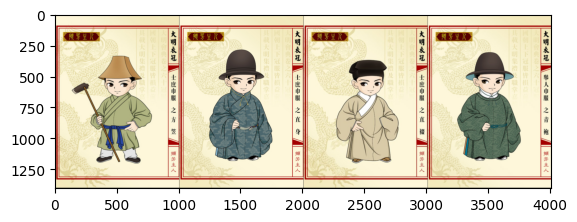

In [100]:
show_images(nn.Upsample(scale_factor = 2)(x))

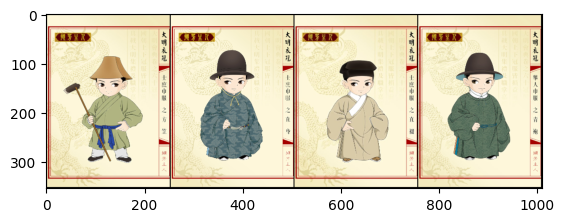

In [101]:
show_images(nn.MaxPool2d(2)(x))

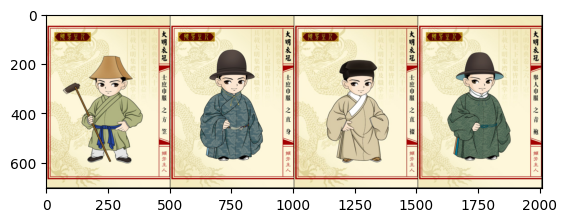

In [102]:
show_images(x)

In [104]:
net = BasicUNet()
# x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([4, 3, 700, 500])

In [105]:
sum([p.numel() for p in net.parameters()])

312259

In [ ]:
for 